In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
#rcParams['text.usetex'] = True
#rcParams['font.family'] = 'serif'
import pandas as pd
#import ChiantiPy.core as ch
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import juanfit

In [2]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value

In [3]:
awsom_data_set = scipy.io.readsav("../../awsom/streamer_sample/awsom_cr2107_cut.sav",verbose = True,python_dict=True)

--------------------------------------------------
Date: Sun Aug 23 03:35:19 2020
User: yjzhu
Host: Yingjies-MacBook-Pro.local
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 5 records of which:
 - 2 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - x [<class 'numpy.ndarray'>]
 - w [<class 'numpy.ndarray'>]
--------------------------------------------------


In [4]:
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
#n = np.nan_to_num(n,nan=0)
ux = awsom_data_set['w'][1,:,:,:]
uy = awsom_data_set['w'][2,:,:,:]
uz = awsom_data_set['w'][3,:,:,:]
bx = awsom_data_set['w'][4,:,:,:]
by = awsom_data_set['w'][5,:,:,:]
bz = awsom_data_set['w'][6,:,:,:]
I01 = awsom_data_set['w'][7,:,:,:]
I02 = awsom_data_set['w'][8,:,:,:]
p = awsom_data_set['w'][9,:,:,:]
t = p/n/k_b
#t = np.nan_to_num(t,nan=1e3)
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
t_e = np.nan_to_num(t_e,nan=1e3)
n = np.nan_to_num(n,nan=1)
n = n + 1
b_tot = np.sqrt(np.square(bx) + np.square(by) + np.square(bz))
u_tot = np.sqrt(np.square(ux) + np.square(uy) + np.square(uz))
bx_rot = np.zeros_like(bx)
by_rot = np.zeros_like(by)
bz_rot = np.zeros_like(bz)
ux_rot = np.zeros_like(ux)
uy_rot = np.zeros_like(uy)
uz_rot = np.zeros_like(uz)

rot_DD = np.array([[0.57707363367080688,0.80787801742553711,-0.11966264247894287],
                   [-0.81372493505477905,0.58125013113021851,0.0000000000000000],
                   [ 6.9553926587104797E-002,9.7372472286224365E-002,0.99281460046768188]])
for ii in range(ux.shape[0]):
    for jj in range(ux.shape[1]):
        for kk in range(ux.shape[2]):
            bx_rot[ii,jj,kk],by_rot[ii,jj,kk],bz_rot[ii,jj,kk] = np.matmul([bx[ii,jj,kk],by[ii,jj,kk],bz[ii,jj,kk]],rot_DD.T)
            ux_rot[ii,jj,kk],uy_rot[ii,jj,kk],uz_rot[ii,jj,kk] = np.matmul([ux[ii,jj,kk],uy[ii,jj,kk],uz[ii,jj,kk]],rot_DD.T)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_42071/1845135539.py:16: RuntimeWarning: invalid value encountered in divide
  t = p/n/k_b
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_42071/1845135539.py:19: RuntimeWarning: invalid value encountered in divide
  t_e = p_e/n/k_b


In [5]:
angle_1 = np.deg2rad(73 + 180)
angle_2 = np.deg2rad(35)
x_interp = np.cos(angle_1)*1.05 - np.linspace(0,1,101)*np.cos(angle_2) 
y_interp = np.sin(angle_1)*1.05 - np.linspace(0,1,101)*np.sin(angle_2)
r_interp = np.sqrt(x_interp**2 + y_interp**2)

In [6]:
awsom_x.shape

(601,)

In [7]:
t_e.shape

(61, 2, 601)

In [8]:
temp_func = interpolate.RegularGridInterpolator(points=(awsom_x,awsom_z),
                    values=t_e[:,0,:].T,
                    bounds_error=False,method="cubic")
temp_interp = temp_func((x_interp, y_interp))

In [9]:
dens_func = interpolate.RegularGridInterpolator(points=(awsom_x,awsom_z),
                    values=n[:,0,:].T,
                    bounds_error=False,method="cubic")
dens_interp = dens_func((x_interp, y_interp))

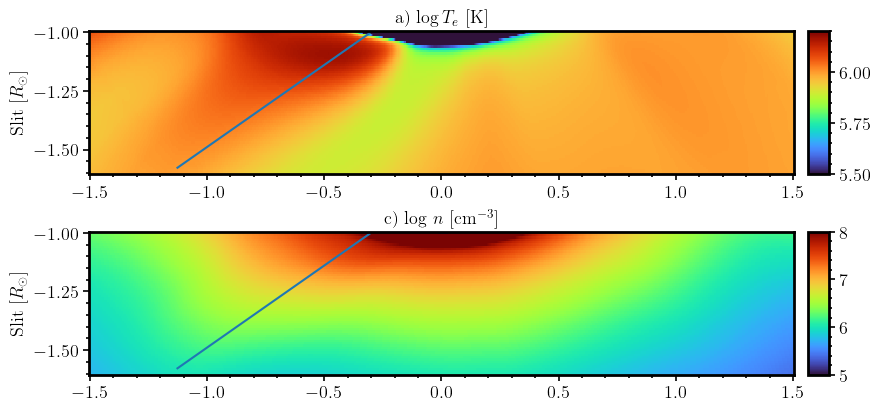

In [10]:
fig, axes = plt.subplots(2,1,figsize=(10,4),constrained_layout=True)
im = axes[0].pcolormesh(awsom_x,awsom_z,np.log10(t_e[:,0,:]),rasterized=True,vmin=5.5,vmax=6.2,cmap="turbo")
axes[0].axis('scaled')
axes[0].set_ylabel(r'Slit $[R_\odot]$',fontsize=13)
axes[0].set_title(r'a) $\log T_e\ \mathrm{[K]}$',fontsize=13)
axes[0].tick_params(labelsize=13)
clb_ax00 = inset_axes(axes[0],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[0].transAxes,
                 borderpad=0)
clb00 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[0],cax=clb_ax00)
clb_ax00.tick_params(labelsize=13)
clb_ax00.yaxis.set_minor_locator(AutoMinorLocator(5))
clb_ax00.yaxis.get_offset_text().set_fontsize(15)

im = axes[1].pcolormesh(awsom_x,awsom_z,np.log10(n[:,0,:]),vmin=5,vmax=8,rasterized=True,cmap="turbo")
axes[1].set_ylabel(r'Slit $[R_\odot]$',fontsize=13)
axes[1].axis('scaled')
axes[1].set_title(r'c) log $n\ \mathrm{[cm^{-3}]}$',fontsize=13)
axes[1].tick_params(labelsize=13)
clb_ax10 = inset_axes(axes[1],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[1].transAxes,
                 borderpad=0)
clb10 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[1],cax=clb_ax10)
clb_ax10.tick_params(labelsize=13)
clb_ax10.yaxis.get_offset_text().set_fontsize(15)
clb_ax10.yaxis.set_minor_locator(AutoMinorLocator(5))

for ax_ in axes.flatten():
    ax_.plot(x_interp,y_interp)
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.2,length=4)
    ax_.tick_params(which="minor",width=1.2,length=2)
    
for ax_ in [clb_ax00,clb_ax10]:
    ax_.tick_params(which="major",width=1.2,length=4)
    ax_.tick_params(which="minor",width=1.2,length=2)

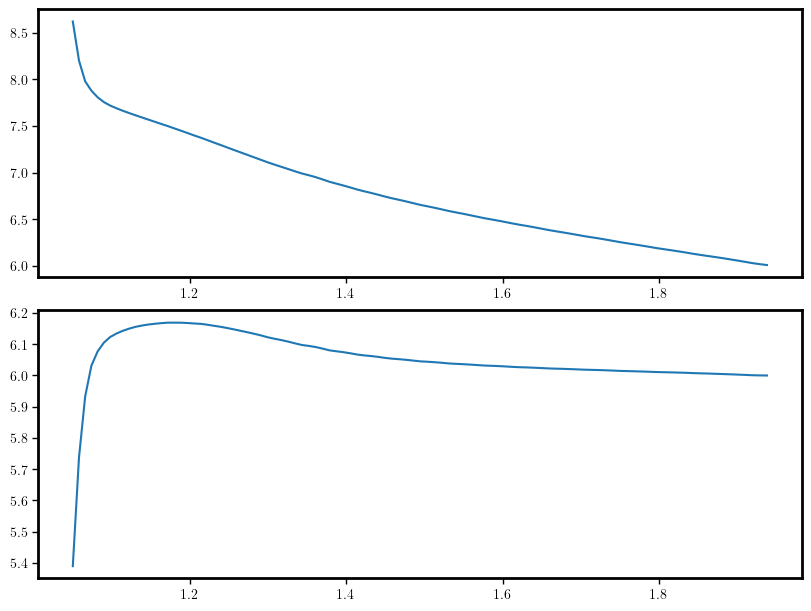

In [11]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6),constrained_layout=True)
ax1.plot(r_interp, np.log10(dens_interp))
ax2.plot(r_interp,np.log10(temp_interp))

In [12]:
df_streamer = pd.DataFrame({"r":r_interp, "dens":dens_interp, "temp":temp_interp})
df_streamer

,r,dens,temp
0,1.050000,4.150601e+08,2.451551e+05
1,1.057898,1.585019e+08,5.457357e+05
2,1.065831,9.499509e+07,8.569416e+05
3,1.073799,7.535051e+07,1.074744e+06
4,1.081801,6.405212e+07,1.194547e+06
...,...,...,...
96,1.900718,1.143368e+06,1.006326e+06
97,1.910125,1.108867e+06,1.004088e+06
98,1.919538,1.073962e+06,1.001595e+06
99,1.928957,1.047473e+06,1.000422e+06


In [13]:
df_streamer.to_csv("../../sav/AWSoM/streamer_example.csv",sep=",",float_format="%.4g",index=False)